In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torch.optim as optim
from datagen import *
from nets import *
from backdoor import Backdoor
from defense import Defense, Prune
from copy import deepcopy


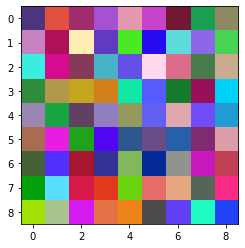

In [158]:
img = ImagePatch((9, 9), 3, 'random')
patch = ImagePatch((3, 3), 3, 'uniform')
threshold = 450

for i in range(img.shape[0] - patch.shape[0]):
    for j in range(img.shape[1] - patch.shape[1]):
        local = img.get_data()[i:i + patch.shape[0], j:j + patch.shape[1], :]
        dist = np.linalg.norm(local - patch.get_data())
        if dist <= threshold:
            data = img.get_data()
            data[i: i + patch.shape[0], j: j + patch.shape[1], :] = 0
            img.set_data(data)
            break
    break
img.show()

In [2]:
backdoor = Backdoor(VggNet, config='11-layer', channels=1, classes=10)
backdoor.create_models(optim.SGD, nn.CrossEntropyLoss, lr=0.01)
backdoor.load_data(torchvision.datasets.MNIST, ImageEntity)
classes = backdoor.get_classes()

n = len(backdoor)
targets = {i: i + 1 if i < 9 else 0 for i in range(10)}
patches = ImagePatch((10, 10), 1, 'random').get_patches(n)
modifications = ([ExpandTransform(1)], [RotateTransform()], [LabelTransform(targets)])
merge = OverlayMerge(select=True)
backdoor.poison(patches, modifications, merge, 0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
backdoor.train(2, epochs=1, verbose=True, device=device)

Training started
Epoch 1/1 | 24.96% | Loss: 0.2630 | Samples trained: 14976/60000
Epoch 1/1 | 49.92% | Loss: 0.1684 | Samples trained: 29952/60000
Epoch 1/1 | 74.88% | Loss: 0.1322 | Samples trained: 44928/60000
Epoch 1/1 | 99.84% | Loss: 0.1109 | Samples trained: 59904/60000
Epoch 1 complete | Loss: 0.1110
Training complete | Net Average Loss: 0.1110 | Total epochs: 1
Training started
Epoch 1/1 | 24.96% | Loss: 0.5459 | Samples trained: 14976/60000
Epoch 1/1 | 49.92% | Loss: 0.3499 | Samples trained: 29952/60000
Epoch 1/1 | 74.88% | Loss: 0.2720 | Samples trained: 44928/60000
Epoch 1/1 | 99.84% | Loss: 0.2281 | Samples trained: 59904/60000
Epoch 1 complete | Loss: 0.2281
Training complete | Net Average Loss: 0.2281 | Total epochs: 1


(0.11103286661546832, 0.22812099889749662)

In [4]:
backdoor.eval(verbose=True, device=device)

Accuracy on Clean | Base 98.57% | Trojan 98.89% | Difference 0.32%
Base Accuracy on Poison 1.15% | Attack Success Rate (ASR): 92.80%
Average Tensor Distance: 282.28 | Net Tensor Difference 16936666.65


(0.9857, 0.9889, 0.0115, 0.928, 282.27777752685546, 16936666.651611328)

In [5]:
defense = Defense(backdoor)
defense.detect(threshold=0.8, device=device)

Accuracy on Poison 92.80% | Likelihood: High


True

In [6]:

defense.view_named_modules()

avgpool: AdaptiveAvgPool2d(output_size=(7, 7))
drop: Dropout(p=0.5, inplace=False)
fc1: Linear(in_features=25088, out_features=4096, bias=True)
fc2: Linear(in_features=4096, out_features=4096, bias=True)
fc3: Linear(in_features=4096, out_features=10, bias=True)
layers: Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [7]:
defense.eval(verbose=True, device=device)

Accuracy on clean | Base 98.57% | Trojan 98.89% | Defense 98.89%
Accuracy on Posion | Base 1.15% | Defense 92.80% | Trojan ASR 92.80%
Difference from Baseline | Trojan 0.32% | Defense 0.32%
Defense Effectiveness | 0.00% no change in ASR


(0.9857, 0.0115, 0.9889, 0.928, 0.9889, 0.928)

In [19]:
defense.prune(['layers.16', 'layers.18'], ['weight'], Prune('ru', amount=0.8))

In [9]:
defense.retrain(verbose=True, device=device)

Training started
Epoch 1/3 | 24.96% | Loss: 0.1117 | Samples trained: 14976/60000
Epoch 1/3 | 49.92% | Loss: 0.1084 | Samples trained: 29952/60000
Epoch 1/3 | 74.88% | Loss: 0.1078 | Samples trained: 44928/60000
Epoch 1/3 | 99.84% | Loss: 0.1042 | Samples trained: 59904/60000
Epoch 1 complete | Loss: 0.1042
Epoch 2/3 | 24.96% | Loss: 0.1118 | Samples trained: 14976/60000
Epoch 2/3 | 49.92% | Loss: 0.1078 | Samples trained: 29952/60000
Epoch 2/3 | 74.88% | Loss: 0.1079 | Samples trained: 44928/60000
Epoch 2/3 | 99.84% | Loss: 0.1036 | Samples trained: 59904/60000
Epoch 2 complete | Loss: 0.1036
Epoch 3/3 | 24.96% | Loss: 0.1112 | Samples trained: 14976/60000
Epoch 3/3 | 49.92% | Loss: 0.1070 | Samples trained: 29952/60000
Epoch 3/3 | 74.88% | Loss: 0.1067 | Samples trained: 44928/60000
Epoch 3/3 | 99.84% | Loss: 0.1033 | Samples trained: 59904/60000
Epoch 3 complete | Loss: 0.1033
Training complete | Net Average Loss: 0.1037 | Total epochs: 3


0.10372725792113277

In [20]:
defense.eval(verbose=True, device=device)

Accuracy on clean | Base 98.57% | Trojan 98.89% | Defense 9.82%
Accuracy on Posion | Base 1.15% | Defense 10.10% | Trojan ASR 92.80%
Difference from Baseline | Trojan 0.32% | Defense -88.75%
Defense Effectiveness | 82.70% decrease in ASR


(0.9857, 0.0115, 0.9889, 0.928, 0.0982, 0.101)

In [21]:
backdoor.get_datasets()[3].get_dataloader().dataset[0][0].size()

torch.Size([28, 28, 1])